# Make intended "Figure 1" for spectral ice paper

### Jonah Shaw, 09/20/2021

Four panels (potentially more) with contour plots of observed monthly trends  
1. dT/dt (GISStemp or HadCrut?)  
2. Ice extent trend (need to find gridded monthly product)
3. CERES ASR (03/2000 - 02/2020 or 01/2001 - 01/2020)
4. CERES OLR (03/2000 - 02/2020 or 01/2001 - 01/2020)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load datasets

CERES, GISStemp, HadSST, NSIDC

## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [2]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [3]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [4]:
giss_tsel = giss1.sel(time=slice('2000-03','2021-03'))['air']

In [5]:
giss1.close()

## Load HadSST3.1 data

Haven't used this before, but trying to find something with temperature records from the Arctic.

In [6]:
hadsst_path = '/glade/work/jonahshaw/obs/HadSST3.0/'
hadsst_file = 'HadSST.3.1.1.0.median.nc'

In [7]:
hadsst = xr.open_dataset('%s/%s' % (hadsst_path,hadsst_file))['sst']

## Load NSIDC data

Using the G10010 V2 product for now.

The ancilliary data has the lat/lon point for each gridcell

In [6]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [7]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))

Using the G02202 V4 product (recommended by Walt Meier)

In [10]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/'

In [11]:
g02202_files = glob.glob('%s*.nc' % (g02202_path))
g02202_files.sort()

In [12]:
g02202_ancilliary = xr.open_dataset(g02202_files[0])
g02202_test = xr.open_dataset(g02202_files[1])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigne

In [19]:
g02202_test['cdr_seaice_conc_monthly'][0]

<xarray.DataArray 'cdr_seaice_conc_monthly' (y: 448, x: 304)>
array([[0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       ...,
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2000-01-01
    xgrid    (x) float32 -3837500.0 -3812500.0 ... 3712500.0 3737500.0
    ygrid    (y) float32 5837500.0 5812500.0 5787500.0 ... -5312500.0 -5337500.0
Dimensions without coordinates: y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]

This is wack

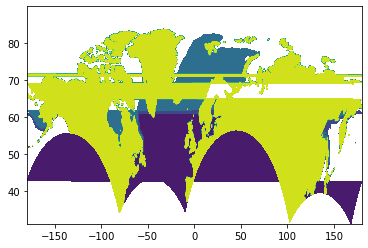

In [23]:
plt.contourf(g02202_ancilliary['longitude'],g02202_ancilliary['latitude'],g02202_test['cdr_seaice_conc_monthly'][0])

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [8]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [9]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data
if os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
    ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)
    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)) or (not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
    
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
        ceres_asr = all_ceres['solar_mon'] - all_ceres['toa_sw_all_mon']
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [11]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

In [12]:
def vectorized_linregress(data):
    '''
    Package for my vectorized linregress call. Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
    linregress1d_np,  # first the function
    data,  # now arguments in the order expected by 'regress1_np'
    data.year,
    input_core_dims=[["year"], ["year"],],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[data.dtype for _ in range(5)], # one per output
    )
    
    return regressed_month

## Calculate trends and statistical significance

#### CERES ASR

In [13]:
# Subset data so computations are lighter and significance tests make sense
ceres_asr_subset = ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [14]:
# create empty arrays for needed output
asr_trends = xr.zeros_like(ceres_asr_subset.groupby('time.month').mean('time'))
asr_rvalues = asr_trends.copy()
asr_pvalues = asr_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in ceres_asr_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')    
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    asr_trends[ii] = regressed_month[0]
    asr_rvalues[ii] = regressed_month[2]
    asr_pvalues[ii] = regressed_month[3]

# Calculate statistical significance
N = len(_yearlydata.year)
dof=N-2

tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
t=asr_rvalues*np.sqrt(N-2)/np.sqrt((1-asr_rvalues*asr_rvalues))

statsig_asr=(1-asr_pvalues)*100

#### CERES OLR

In [15]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [16]:
# create empty arrays for needed output
olr_trends = xr.zeros_like(ceres_olr_subset.groupby('time.month').mean('time'))
olr_rvalues = olr_trends.copy()
olr_pvalues = olr_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in ceres_olr_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    olr_trends[ii] = regressed_month[0]
    olr_rvalues[ii] = regressed_month[2]
    olr_pvalues[ii] = regressed_month[3]
    
# Calculate statistical significance
N = len(_yearlydata.year)
dof = N - 2

tcrit = stats.t.ppf(0.975,dof)  ## two-sided 95%
t = olr_rvalues * np.sqrt(N - 2) / np.sqrt((1 - olr_rvalues * olr_rvalues))

statsig_olr = (1 - olr_pvalues) * 100 # student's two-tailed t-test
notnull_olr = t > tcrit # disproving the null hypothesis (slope is zero)

#### Temperature from GISStemp

In [17]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [18]:
# create empty arrays for needed output
gisstemp_trends = xr.zeros_like(gisstemp_subset.groupby('time.month').mean('time'))
gisstemp_rvalues = gisstemp_trends.copy()
gisstemp_pvalues = gisstemp_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in gisstemp_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    gisstemp_trends[ii] = regressed_month[0]
    gisstemp_rvalues[ii] = regressed_month[2]
    gisstemp_pvalues[ii] = regressed_month[3]

# Calculate statistical significance
N = len(_yearlydata.year)
dof = N - 2

tcrit = stats.t.ppf(0.975,dof)  ## two-sided 95%
t = gisstemp_rvalues * np.sqrt(N - 2) / np.sqrt((1 - gisstemp_rvalues * gisstemp_rvalues))

statsig_gisstemp = (1 - gisstemp_pvalues) * 100 # student's two-tailed t-test
notnull_gisstemp = t > tcrit # disproving the null hypothesis (slope is zero)

#### Ice Concentration from NSIDC G10010

In [19]:
try:
    nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
except:
    pass

# Subset by time and latitude
g10010_tsel = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))

# Need to perform a masked and weighted average because areas are not constant and land cells must be masked
g10010_subset = masked_average(g10010_tsel['seaice_conc'],dim=['lon'],
                                      weights=g10010_tsel['Gridcell_Area'],mask=(g10010_tsel['LandRegion_mask']==20))

In [20]:
# create empty arrays for needed output
g10010_trends = xr.zeros_like(g10010_subset.groupby('time.month').mean('time'))
g10010_rvalues = g10010_trends.copy()
g10010_pvalues = g10010_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in g10010_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    g10010_trends[ii] = regressed_month[0]
    g10010_rvalues[ii] = regressed_month[2]
    g10010_pvalues[ii] = regressed_month[3]
    
# Calculate statistical significance
N = len(_yearlydata.year)
dof = N - 2

tcrit = stats.t.ppf(0.975,dof)  ## two-sided 95%
t = g10010_rvalues * np.sqrt(N - 2) / np.sqrt((1 - g10010_rvalues * g10010_rvalues))

statsig_g10010 = (1 - g10010_pvalues) * 100 # student's two-tailed t-test
notnull_g10010 = t > tcrit # disproving the null hypothesis (slope is zero)

#### Wrap data for better visualization

In [42]:
outtie = xr.concat([asr_trends,asr_trends[0].assign_coords({'month':13})],dim='month')

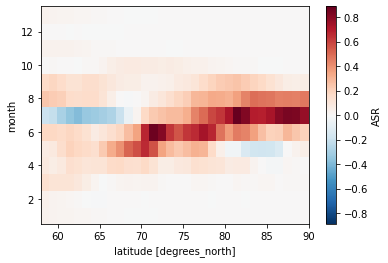

In [43]:
outtie.plot()

### Plot summary data

#### Wrap data

In [38]:
files = [gisstemp_trends,statsig_gisstemp,
         g10010_trends,statsig_g10010,
         asr_trends,statsig_asr,
         olr_trends,statsig_olr]

for _file in files:
    _file = xr.concat([_file,_file[0].assign_coords({'month':13})],dim='month')

In [46]:
gisstemp_trends_wrapped = xr.concat([gisstemp_trends,gisstemp_trends[0].assign_coords({'month':13})],dim='month')
statsig_gisstemp_wrapped = xr.concat([statsig_gisstemp,statsig_gisstemp[0].assign_coords({'month':13})],dim='month')

g10010_trends_wrapped = xr.concat([g10010_trends,g10010_trends[0].assign_coords({'month':13})],dim='month')
statsig_g10010_wrapped = xr.concat([statsig_g10010,statsig_g10010[0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([asr_trends,asr_trends[0].assign_coords({'month':13})],dim='month')
statsig_asr_wrapped = xr.concat([statsig_asr,statsig_asr[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
statsig_olr_wrapped = xr.concat([statsig_olr,statsig_olr[0].assign_coords({'month':13})],dim='month')

In [75]:
# palette = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)

# palette = sns.color_palette("vlag", as_cmap=True)

# palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# palette = cmaps.ncl_default

# palette = sns.color_palette("coolwarm", as_cmap=True)

# palette = sns.diverging_palette(200, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

In [72]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43026136111758173, 0.6200066482697917, 0.6787801878373952),
 (0.6085255804707219, 0.7412795877319109, 0.7824000973141302),
 (0.786789799823862, 0.86255252719403, 0.8860200067908652),
 (0.95, 0.95, 0.95),
 (0.954577257933482, 0.7665309859226215, 0.7803256889894359),
 (0.9197182699854205, 0.5873587656270927, 0.6117400023569117),
 (0.884859282037359, 0.40818654533156384, 0.4431543157243877),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

In [ ]:
fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)
    
lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
im0 = axes[0].contourf(gisstemp_trends_wrapped['month'],lat_weighted0,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-0.1,vmax=0.4))
stip = axes[0].contourf(statsig_gisstemp_wrapped['month'],lat_weighted0,statsig_gisstemp_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='K/yr')

lat_weighted1 = np.sin(np.pi/180*g10010_trends['lat'])
im1 = axes[1].contourf(g10010_trends_wrapped['month'],lat_weighted1,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-1.75,vmax=0.5))
stip = axes[1].contourf(g10010_trends_wrapped['month'],lat_weighted1,statsig_g10010_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='%/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-0.4,vmax=1.0))#,levels=np.arange(-1.0,1.01,0.2))
stip = axes[2].contourf(statsig_asr_wrapped['month'],lat_weighted2,statsig_asr_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-0.2,vmax=0.5),levels=np.arange(-0.2,0.51,0.1))
stip = axes[3].contourf(statsig_olr_wrapped['month'],lat_weighted3,statsig_olr_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


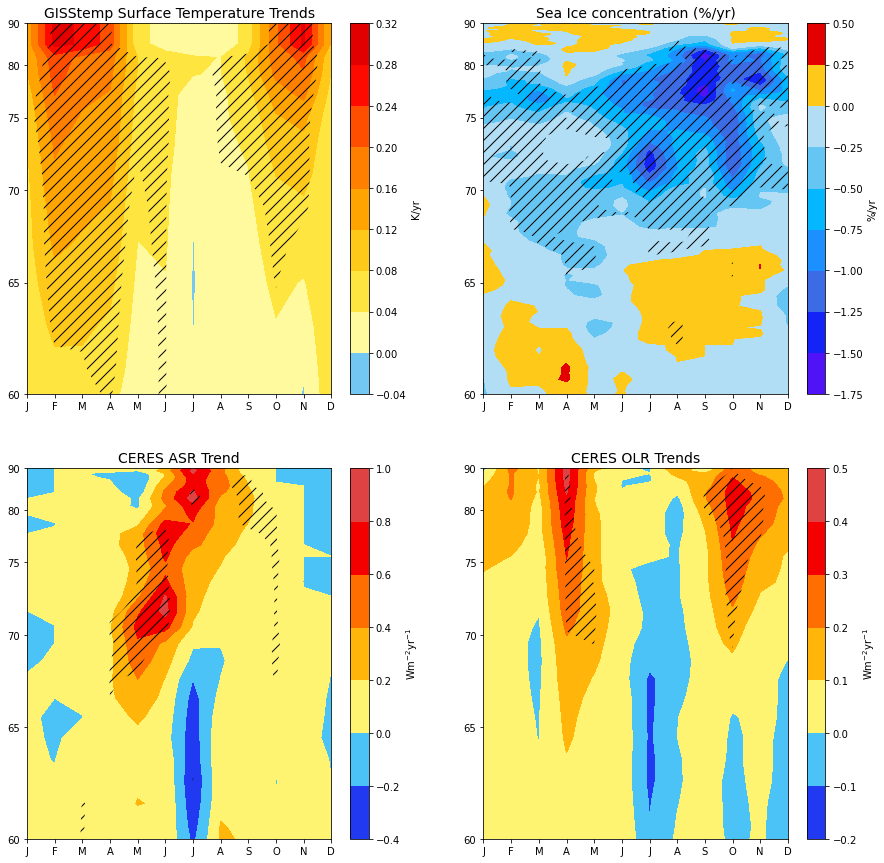

In [45]:
fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
xticks = np.arange(1,12.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)
    
lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
im0 = axes[0].contourf(gisstemp_trends['month'],lat_weighted0,gisstemp_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.1,vmax=0.4))
stip = axes[0].contourf(statsig_gisstemp['month'],lat_weighted0,statsig_gisstemp.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='K/yr')

lat_weighted1 = np.sin(np.pi/180*g10010_trends['lat'])
im1 = axes[1].contourf(g10010_trends['month'],lat_weighted1,g10010_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-1.75,vmax=0.5))
stip = axes[1].contourf(g10010_trends['month'],lat_weighted1,statsig_g10010.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Sea Ice concentration (%/yr)',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='%/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
im2 = axes[2].contourf(asr_trends['month'],lat_weighted2,asr_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.4,vmax=1.0))#,levels=np.arange(-1.0,1.01,0.2))
stip = axes[2].contourf(statsig_asr['month'],lat_weighted2,statsig_asr.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
im3 = axes[3].contourf(olr_trends['month'],lat_weighted3,olr_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.2,vmax=0.5),levels=np.arange(-0.2,0.51,0.1))
stip = axes[3].contourf(statsig_olr['month'],lat_weighted3,statsig_olr.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')
